# Movie Recommendation Using LightFM Model

---

![Banner Image](banner.png)

---

## Content Table

- [1. Introduction](#1.-introduction)
- [2. Setup and Imports](#2.-setup-and-imports)
- [3. Data Preprocessing](#3.-data-preprocessing)
    - [A- User Interatctions](#A--user-interactions)
    - [B- Movie Features](#B--movie-features)
    - [C- User Features](#C--user-features)
- [4. Dataset Preparation](#4.-dataset-preparation)
    - [A- Interactions](#A--interactions)
    - [B- Movie Features](#B--movie-features)
    - [C- User Features](#C--user-features)
- [5. Model Training](#5.-model-training)
- [6. Model Evaluation](#6.-model-evaluation)
- [7. Cross-Validation](#7.-cross-validation)
- [8. Predictions and Recommendations](#8.-predictions-and-recommendations)
- [9. Interpretation](#9.-interpretation)

---

## 1. Introduction

##### In this notebook, we develop a movie recommendation system using the LightFM model, a hybrid matrix factorization technique that incorporates both collaborative and content-based filtering. The goal is to predict and recommend movies to users based on their interaction history and item features.

---

## 2. Setup and Imports

In [167]:
import pandas as pd
import numpy as np
from lightfm import LightFM

random_state = 42  # for reproducibility

In [168]:
original_ratings = pd.read_csv("Data/archive/rating.csv")

In [169]:
original_movies_df = pd.read_csv("Data/archive/movie.csv")

In [170]:
ratings_df = pd.read_csv("Data/rating_user_IQR.csv")

In [171]:
movies_df = pd.read_csv("Data/movie_user_IQR.csv")

---

## 3. Data Preprocessing

### A- User Interactions

In this section we will prep the data from the ratings set to use it in the interactions matrix

In [172]:
# Set the data types for the columns for easier memory management and faster computations
ratings_df["userId"] = ratings_df["userId"].astype("int32")
ratings_df["movieId"] = ratings_df["movieId"].astype("int32")
ratings_df["rating"] = ratings_df["rating"].astype("float32")

In [173]:
ratings_df.head(2)

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5


In [174]:
ratings_df.shape

(9962336, 3)

In [175]:
# Change ratings to binary as >= 4 is a positive interaction
ratings_df["rating"] = ratings_df["rating"].apply(lambda x: 1 if x >= 4 else 0)

In [176]:
ratings_df.values

array([[     1,      2,      0],
       [     1,     29,      0],
       [     1,     32,      0],
       ...,
       [138493,  69644,      0],
       [138493,  70286,      1],
       [138493,  71619,      0]])

### B- Movie Features

In this section we prep the movie features. We will use the genres of the movies.

In [177]:
movies_df.head(2)

,movieId,title,genres,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
movies_df.columns

Index(['movieId', 'title', 'genres', 'year', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [179]:
movies_df.drop(
    ["title", "year","genres"],
    inplace=True,
    axis=1,
)

In [180]:
movies_df.head(2)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [181]:
# Create a list of all the genres
genres = movies_df.columns.drop(["movieId"])

In [182]:
genres

Index(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [183]:
# Create a new column "genres" in the movies_df DataFrame
# For each row, apply a lambda function that:
# - Iterates over the list of genres
# - Checks if the value in the genre column is 1
# - If true, includes the genre in the list for that row
movies_df["genres"] = movies_df[genres].apply(
    lambda row: [col for col in genres if row[col] == 1], axis=1
)

movies_df.head(2)

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[Adventure, Children, Fantasy]"


In [184]:
# Conver the genre's list to tuples with movieId and its genres
movie_features_matrix=list(zip(movies_df.movieId, movies_df.genres))
movie_features_matrix[0]

(1, ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'])

### C. User Features

In this part we prep the user features which will be the distribution of genres watched by the user over time

In [185]:
# Add the genres to the ratings_df by merging on movieId
user_genres = ratings_df.merge(
    movies_df.drop(["genres"], axis=1), on="movieId", how="left"
).drop(["movieId", "rating"], axis=1)

In [186]:
user_genres.head(2)

,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0


In [187]:
# Sum all genres viewed by each user
user_genres = user_genres.groupby("userId").sum()

In [188]:
user_genres

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,66,73,10,19,41,21,0,43,69,0,45,2,3,18,11,40,42,9,4
3,61,50,4,10,52,21,1,58,20,1,32,0,6,11,16,93,50,6,3
7,61,59,7,17,122,17,0,130,23,4,11,1,9,16,112,68,45,17,9
11,223,163,66,71,145,58,7,149,84,2,78,27,15,30,59,229,171,14,2
14,33,72,47,72,140,12,0,89,44,0,1,4,31,8,76,35,18,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138483,53,30,9,16,91,37,1,164,19,2,8,3,10,14,68,20,64,11,6
138484,52,27,3,6,47,33,1,68,9,0,8,2,3,11,29,19,58,8,5
138486,63,51,14,24,72,18,1,50,40,0,79,6,9,17,18,41,83,4,1


In [189]:
# Calculate the distribution of genres viewed by each user
user_genres = user_genres.div(user_genres.sum(axis=1), axis=0)
user_genres.head(2)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,0.127907,0.141473,0.019380,0.036822,0.079457,0.040698,0.00000,0.083333,0.133721,0.00000,0.087209,0.003876,0.005814,0.034884,0.021318,0.077519,0.081395,0.017442,0.007752
3,0.123232,0.101010,0.008081,0.020202,0.105051,0.042424,0.00202,0.117172,0.040404,0.00202,0.064646,0.000000,0.012121,0.022222,0.032323,0.187879,0.101010,0.012121,0.006061


In [190]:
user_genres = user_genres.round(2)
user_genres.head(2)

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,0.13,0.14,0.02,0.04,0.08,0.04,0.0,0.08,0.13,0.0,0.09,0.0,0.01,0.03,0.02,0.08,0.08,0.02,0.01
3,0.12,0.10,0.01,0.02,0.11,0.04,0.0,0.12,0.04,0.0,0.06,0.0,0.01,0.02,0.03,0.19,0.10,0.01,0.01


In [191]:
# Convert the features to the lightfm usable format
user_features = list(zip(user_genres.index, user_genres.to_dict(orient="records")))
user_features[0]

(1,
 {'Action': 0.13,
  'Adventure': 0.14,
  'Animation': 0.02,
  'Children': 0.04,
  'Comedy': 0.08,
  'Crime': 0.04,
  'Documentary': 0.0,
  'Drama': 0.08,
  'Fantasy': 0.13,
  'Film-Noir': 0.0,
  'Horror': 0.09,
  'IMAX': 0.0,
  'Musical': 0.01,
  'Mystery': 0.03,
  'Romance': 0.02,
  'Sci-Fi': 0.08,
  'Thriller': 0.08,
  'War': 0.02,
  'Western': 0.01})

---

## 4. Dataset preparation

In this section we prep the dataset for the model training and testing

In [192]:
from lightfm.data import Dataset

# Create a dataset object
dataset = Dataset()

In [193]:
# Use lightfm's inbuilt fit method to map the users, items and features to the dataset
dataset.fit(
    users=ratings_df["userId"],
    items=ratings_df["movieId"],
    item_features=genres,
    user_features=genres,
)

In [194]:
nb_users, nb_items = dataset.interactions_shape()
print(f"Number of users: {nb_users}\t Number of movies: {nb_items}")

Number of users: 38105	 Number of movies: 19658


In [195]:
nb_movies, nb_features = dataset.item_features_shape()
print(f"Number of movies: {nb_movies}\t Number of movie features: {nb_features}")

Number of movies: 19658	 Number of movie features: 19677


In [196]:
nb_users, nb_features = dataset.user_features_shape()
print(f"Number of users: {nb_users}\t Number of user features: {nb_features}")

Number of users: 38105	 Number of user features: 38124


### A- Interactions

In [197]:
# Build the interactions matrix
interactions, weights = dataset.build_interactions(ratings_df.values)

In [198]:
# Split the data into train and test sets
from lightfm.cross_validation import random_train_test_split

train_interactions, test_interactions = random_train_test_split(
    interactions, test_percentage=0.7, random_state=random_state
)
train_weights, test_weights = random_train_test_split(
    weights, test_percentage=0.7, random_state=random_state
)

In [199]:
train_interactions, test_interactions

(<38105x19658 sparse matrix of type '<class 'numpy.int32'>'
 	with 2988700 stored elements in COOrdinate format>,
 <38105x19658 sparse matrix of type '<class 'numpy.int32'>'
 	with 6973636 stored elements in COOrdinate format>)

In [200]:
train_weights, test_weights

(<38105x19658 sparse matrix of type '<class 'numpy.float32'>'
 	with 2988700 stored elements in COOrdinate format>,
 <38105x19658 sparse matrix of type '<class 'numpy.float32'>'
 	with 6973636 stored elements in COOrdinate format>)

### B- Movies Features

In [201]:
# Build the user features matrix
processed_movie_features = dataset.build_item_features(movie_features_matrix)

### C- User Features

In [202]:
# Build the user features matrix
processed_user_features = dataset.build_user_features(user_features)

---

## 5. Model Training

In [204]:
# initialize the model with warp loss function and adagrad learning schedule and 100 components for embedding
model = LightFM(
    loss="warp",
    learning_schedule="adagrad",
    no_components=100,
    random_state=random_state,
)

# Fit the model
model.fit(
    interactions=train_interactions,
    sample_weight=train_weights,
    item_features=processed_movie_features,
    user_features=processed_user_features,
    epochs=50,
    num_threads=14,  # parallelize the training using openmp for multithreading
    verbose=True,
)

Epoch: 100%|██████████| 50/50 [11:59<00:00, 14.39s/it]


In [ ]:
import pickle

# Save the model to a file for future use
with open("Exported_Models/lightfm_recommendation_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
import pickle

# To load the model back
with open("Exported_Models/lightfm_recommendation_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

---

## 6. Model Evaluation

In [205]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Calculate the auc_score for the train and test sets
train_roc_auc = auc_score(
    model,
    train_interactions,
    item_features=processed_movie_features,
    user_features=processed_user_features,
    num_threads=14,
).mean()
test_roc_auc = auc_score(
    model,
    test_interactions,
    item_features=processed_movie_features,
    user_features=processed_user_features,
    num_threads=14,
).mean()

# Calculate the precision for the train and test sets
train_precision = precision_at_k(
    model,
    train_interactions,
    item_features=processed_movie_features,
    user_features=processed_user_features,
    num_threads=14,
).mean()
test_precision = precision_at_k(
    model,
    test_interactions,
    train_interactions=train_interactions,  # this is to ensure that the model does not recommend items that the user has already interacted with
    item_features=processed_movie_features,
    user_features=processed_user_features,
    k=15,
    num_threads=14,
).mean()

# Calculate the recall for the train and test sets
train_recall = recall_at_k(
    model,
    train_interactions,
    item_features=processed_movie_features,
    user_features=processed_user_features,
    num_threads=14,
).mean()
test_recall = recall_at_k(
    model,
    test_interactions,
    train_interactions=train_interactions,
    k=15,
    item_features=processed_movie_features,
    user_features=processed_user_features,
    num_threads=14,
).mean()

In [206]:
print(f"Train ROC AUC: {train_roc_auc:.2f}\tTest ROC AUC: {test_roc_auc:.2f}")
print(f"Train Precision: {train_precision:.2f}\tTest Precision: {test_precision:.2f}")
print(f"Train Recall: {train_recall:.2f}\tTest Recall: {test_recall:.2f}")

Train ROC AUC: 0.97	Test ROC AUC: 0.96
Train Precision: 0.25	Test Precision: 0.69
Train Recall: 0.04	Test Recall: 0.06


---

## 7. Cross-Validation

Reused part of lightfm's train/test split function to create a cross validation function. This one is split as we use train set smaller than the test set

In [ ]:
import scipy.sparse as sp


def _shuffle(uids, iids, data, random_state):
    """
    Shuffle the user IDs, item IDs, and interaction data in unison.

    Parameters:
    - uids: Array of user IDs.
    - iids: Array of item IDs.
    - data: Array of interaction data.
    - random_state: Numpy RandomState object for reproducible shuffling.

    Returns:
    - Shuffled user IDs, item IDs, and interaction data.
    """
    # Create an array of indices based on the length of user IDs
    shuffle_indices = np.arange(len(uids))

    # Shuffle the indices using the provided random state
    random_state.shuffle(shuffle_indices)

    # Return the user IDs, item IDs, and data arrays shuffled in unison
    return uids[shuffle_indices], iids[shuffle_indices], data[shuffle_indices]


def inverse_cross_validation_split(interactions, n_splits=5, random_state=None):
    """
    Split interactions into `n_splits` test sets and `n-1` train sets for inverse cross-validation.

    This function creates `n_splits` folds of the dataset, with each fold being used as the training set,
    and the remaining `n_splits-1` folds combined to form the test set.

    Parameters
    ----------
    interactions: scipy sparse matrix
        The interactions to split.
    n_splits: int, optional
        Number of folds. Must be at least 2.
    random_state: int or numpy.random.RandomState, optional
        Random seed used to initialize the numpy.random.RandomState number generator.
        Accepts an instance of numpy.random.RandomState for backwards compatibility.

    Yields
    ------
    (train, test): (scipy.sparse.COOMatrix, scipy.sparse.COOMatrix)
        A generator yielding `n_splits` tuples of (train data, test data).
    """

    # Check if the interactions matrix is a sparse matrix
    if not sp.issparse(interactions):
        raise ValueError("Interactions must be a scipy.sparse matrix.")

    # Ensure the random_state is a numpy RandomState object
    if not isinstance(random_state, np.random.RandomState):
        random_state = np.random.RandomState(seed=random_state)

    # Convert the interactions matrix to COO format for easier manipulation
    interactions = interactions.tocoo()
    shape = interactions.shape  # Get the shape of the interactions matrix
    uids, iids, data = (
        interactions.row,
        interactions.col,
        interactions.data,
    )  # Extract row, column, and data arrays

    # Shuffle the user IDs, item IDs, and data using the random state
    uids, iids, data = _shuffle(uids, iids, data, random_state)

    # Calculate the size of each fold for cross-validation
    fold_size = len(uids) // n_splits

    # Perform cross-validation splitting
    for i in range(n_splits):
        # Determine the start and end indices for the training set in the current fold
        train_start = i * fold_size
        train_end = (i + 1) * fold_size if i < n_splits - 1 else len(uids)

        # Create slices for the training and testing indices
        train_idx = slice(train_start, train_end)
        test_idx = np.concatenate(
            [np.arange(0, train_start), np.arange(train_end, len(uids))]
        )

        # Create the training interactions matrix for the current fold
        train = sp.coo_matrix(
            (data[train_idx], (uids[train_idx], iids[train_idx])),
            shape=shape,
            dtype=interactions.dtype,
        )

        # Create the testing interactions matrix for the current fold
        test = sp.coo_matrix(
            (data[test_idx], (uids[test_idx], iids[test_idx])),
            shape=shape,
            dtype=interactions.dtype,
        )

        # Yield the training and testing matrices for the current fold
        yield train, test

In [ ]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score


def test_model(
    model,
    train_interactions,
    test_interactions,
    processed_movie_features,
    processed_user_features,
):
    """
    Evaluate the performance of the LightFM model using various metrics.

    Parameters:
    - model: The trained LightFM model.
    - train_interactions: Interactions matrix for the training set.
    - test_interactions: Interactions matrix for the testing set.
    - processed_movie_features: Preprocessed features of the movies.
    - processed_user_features: Preprocessed features of the users.

    Returns:
    - train_roc_auc: ROC AUC score for the training set.
    - test_roc_auc: ROC AUC score for the testing set.
    - train_precision: Precision at k for the training set.
    - test_precision: Precision at k for the testing set.
    - train_recall: Recall at k for the training set.
    - test_recall: Recall at k for the testing set.
    """

    # Calculate ROC AUC for the training set
    train_roc_auc = auc_score(
        model,
        train_interactions,
        item_features=processed_movie_features,
        user_features=processed_user_features,
        num_threads=14,
    ).mean()

    # Calculate ROC AUC for the testing set
    test_roc_auc = auc_score(
        model,
        test_interactions,
        item_features=processed_movie_features,
        user_features=processed_user_features,
        num_threads=14,
    ).mean()

    # Calculate Precision at k for the training set
    train_precision = precision_at_k(
        model,
        train_interactions,
        item_features=processed_movie_features,
        user_features=processed_user_features,
        num_threads=14,
    ).mean()

    # Calculate Precision at k for the testing set
    test_precision = precision_at_k(
        model,
        test_interactions,
        train_interactions=train_interactions,
        item_features=processed_movie_features,
        user_features=processed_user_features,
        k=15,
        num_threads=14,
    ).mean()

    # Calculate Recall at k for the training set
    train_recall = recall_at_k(
        model,
        train_interactions,
        item_features=processed_movie_features,
        user_features=processed_user_features,
        num_threads=14,
    ).mean()

    # Calculate Recall at k for the testing set
    test_recall = recall_at_k(
        model,
        test_interactions,
        train_interactions=train_interactions,
        k=15,
        item_features=processed_movie_features,
        user_features=processed_user_features,
        num_threads=14,
    ).mean()

    # Print the evaluation results
    print(f"Train ROC AUC: {train_roc_auc:.2f}\tTest ROC AUC: {test_roc_auc:.2f}")
    print(
        f"Train Precision: {train_precision:.2f}\tTest Precision: {test_precision:.2f}"
    )
    print(f"Train Recall: {train_recall:.2f}\tTest Recall: {test_recall:.2f}")

    # Return the evaluation metrics
    return (
        train_roc_auc,
        test_roc_auc,
        train_precision,
        test_precision,
        train_recall,
        test_recall,
    )

In [ ]:
# Number of splits for cross-validation
n_splits = 4

# Dictionary to store the results of each fold
results = {}

# Initialize the LightFM model with WARP loss and Adagrad learning schedule
model = LightFM(loss="warp", learning_schedule="adagrad", random_state=random_state)

# Perform inverse cross-validation split
# This function splits the interactions data into training and testing sets for cross-validation
for i, (train, test) in enumerate(
    inverse_cross_validation_split(
        interactions, n_splits=n_splits, random_state=random_state
    )
):
    print(f"Fold {i + 1}")
    # Fit the model on the training data
    model.fit(
        train,
        epochs=50,
        num_threads=14,
        verbose=True,
        item_features=processed_movie_features,
        user_features=processed_user_features,
    )

    # Evaluate the model on the training and testing data
    # Store the results in the results dictionary with the fold number as the key
    results[i + 1] = test_model(
        model, train, test, processed_movie_features, processed_user_features
    )

    # Print the shapes of the training and testing sets
    print("Train set shape:", train.shape, "Test set shape:", test.shape)

Fold 1


Epoch: 100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


Train ROC AUC: 0.97	Test ROC AUC: 0.97
Train Precision: 0.19	Test Precision: 0.67
Train Recall: 0.03	Test Recall: 0.06
Train set shape: (38105, 19658) Test set shape: (38105, 19658)
Fold 2


Epoch: 100%|██████████| 50/50 [04:04<00:00,  4.89s/it]


Train ROC AUC: 0.97	Test ROC AUC: 0.97
Train Precision: 0.19	Test Precision: 0.67
Train Recall: 0.03	Test Recall: 0.06
Train set shape: (38105, 19658) Test set shape: (38105, 19658)
Fold 3


Epoch: 100%|██████████| 50/50 [04:48<00:00,  5.77s/it]


Train ROC AUC: 0.97	Test ROC AUC: 0.97
Train Precision: 0.19	Test Precision: 0.67
Train Recall: 0.03	Test Recall: 0.06
Train set shape: (38105, 19658) Test set shape: (38105, 19658)
Fold 4


Epoch: 100%|██████████| 50/50 [04:52<00:00,  5.85s/it]


Train ROC AUC: 0.97	Test ROC AUC: 0.97
Train Precision: 0.19	Test Precision: 0.67
Train Recall: 0.03	Test Recall: 0.06
Train set shape: (38105, 19658) Test set shape: (38105, 19658)


---

## 8. Predictions and Recommendations

In [207]:
# Create a reverse mapping of model item IDs to original item IDs
items_mapping = {v: k for k, v in dataset.mapping()[2].items()}

In [208]:
def make_pred(
    user_id,
    model,
    movies_df,
    processed_movie_features,
    processed_user_features,
    nb_preds=10,
):
    """
    Generate movie recommendations for a given user using the LightFM model.

    Parameters:
    - user_id: The ID of the user for whom to make predictions.
    - model: The trained LightFM model.
    - movies_df: DataFrame containing movie information (movieId, title, genres).
    - processed_movie_features: Preprocessed features of the movies.
    - processed_user_features: Preprocessed features of the users.
    - nb_preds: Number of recommendations to generate (default is 10).

    Returns:
    - recommended_movies: DataFrame containing the recommended movies with their titles, genres, and scores.
    """
    # Get the total number of items (movies) in the dataset
    n_items = dataset.item_features_shape()[0]

    # Map the user ID to the internal user ID used by the dataset
    mapped_user_id = dataset.mapping()[0][user_id]

    # Get the list of movies watched by the user
    watched_movies = ratings_df[ratings_df["userId"] == user_id]["movieId"].values

    # Map the watched movie IDs to the internal movie IDs used by the dataset
    mapped_watched_movies = [dataset.mapping()[2][movie] for movie in watched_movies]

    # Get the list of movies that the user has not watched
    non_watched_movies = np.setdiff1d(np.arange(n_items), mapped_watched_movies)

    # Predict the scores for the non-watched movies
    prediction = model.predict(
        user_ids=mapped_user_id,
        item_ids=non_watched_movies,
        item_features=processed_movie_features,
        user_features=processed_user_features,
    )

    # Get the indices of the top-n predicted movies
    predicted_movies = prediction.argsort()[::-1][:nb_preds]

    # Map the internal movie IDs back to the original movie IDs
    results = [items_mapping[item] for item in predicted_movies]

    # Create a DataFrame with the recommended movies, their titles, genres, and scores
    recommended_movies = pd.DataFrame(
        {
            "movieId": results,
            "title": movies_df[movies_df["movieId"].isin(results)]["title"],
            "genres": movies_df[movies_df["movieId"].isin(results)]["genres"],
            "Score": sorted(prediction)[::-1][:nb_preds],
        }
    )

    return recommended_movies

In [209]:
def get_watched_movies(user_id,movies_df):
    """
    Retrieve the list of movies watched by a given user along with their ratings and titles.

    Parameters:
    - user_id: The ID of the user for whom to retrieve watched movies.

    Returns:
    - DataFrame containing the watched movies with their titles and ratings, sorted by rating.
    """
    # Map the user ID to the internal user ID used by the dataset
    mapped_user_id = dataset.mapping()[0][user_id]

    # Get the list of movies watched by the user in the interactions matrix
    watched_movies = interactions.tocsr()[mapped_user_id]

    # Extract the indices of the watched movies
    watched_movies.indices

    # Map the internal movie IDs to the original movie IDs
    mapped_watched_movies = [
        items_mapping[movie_id] for movie_id in watched_movies.indices
    ]

    # Create a DataFrame with the watched movies and their titles
    rated_watched_movies = pd.DataFrame(
        {
            "movieId": mapped_watched_movies,
            "title": movies_df[movies_df.movieId.isin(mapped_watched_movies)].title,
        }
    ).merge(ratings_df[ratings_df.userId == user_id], on="movieId", how="left")

    # Return the watched movies with their ratings and titles, sorted by rating
    return (
        original_ratings[original_ratings.userId == user_id]
        .merge(movies_df, on="movieId", how="left")
        .sort_values("rating", ascending=False)
        .set_index("movieId")
        .loc[rated_watched_movies.sort_values("rating", ascending=False)["movieId"]]
    )

In [210]:
def user_pred(user_id, processed_movie_features, processed_user_features,movies_df, nb_preds=10):
    """
    Display the watched movies and recommended movies for a given user.

    Parameters:
    - user_id: The ID of the user for whom to make predictions.
    - processed_movie_features: Preprocessed features of the movies.
    - processed_user_features: Preprocessed features of the users.
    - nb_preds: Number of recommendations to display (default is 10).
    """
    # Print the header for watched movies
    print("Watched Movies by user ", user_id)
    
    # Display the top-n watched movies by the user
    display(get_watched_movies(user_id,movies_df)[:nb_preds])
    
    # Print the header for recommended movies
    print("Recommended Movies for user ", user_id)
    
    # Display the top-n recommended movies for the user
    display(
        make_pred(
            user_id,
            model,
            movies_df,
            processed_movie_features,
            processed_user_features,
            nb_preds,
        )
    )

In [211]:
# Input the user_id for which you want to make predictions and get the top-n recommendations and the top-n watched movies
user_id = 1
user_pred(
    user_id,
    processed_movie_features=processed_movie_features,
    processed_user_features=processed_user_features,
    movies_df=original_movies_df,
    nb_preds=10,
)

Watched Movies by user  1


,userId,rating,timestamp,title,genres
movieId,,,,,
31696,1,4.0,2005-04-02 23:49:08,Constantine (2005),Action|Fantasy|Horror|Thriller
2100,1,4.0,2005-04-02 23:52:35,Splash (1984),Comedy|Fantasy|Romance
2288,1,4.0,2004-09-10 03:14:37,"Thing, The (1982)",Action|Horror|Sci-Fi|Thriller
5171,1,4.0,2005-04-02 23:55:04,"Time Machine, The (2002)",Action|Adventure|Sci-Fi
5540,1,4.0,2005-04-02 23:51:45,Clash of the Titans (1981),Action|Adventure|Fantasy|Romance
2193,1,4.0,2005-04-02 23:49:13,Willow (1988),Action|Adventure|Fantasy
2174,1,4.0,2005-04-02 23:50:43,Beetlejuice (1988),Comedy|Fantasy
2173,1,4.0,2005-04-02 23:51:27,"Navigator: A Mediaeval Odyssey, The (1988)",Adventure|Fantasy|Sci-Fi
2143,1,4.0,2005-04-02 23:52:31,Legend (1985),Adventure|Fantasy|Romance


Recommended Movies for user  1


,movieId,title,genres,Score
1188,36401,Alien (1979),Horror|Sci-Fi,-178.746597
1193,2918,Psycho (1960),Crime|Horror,-178.956131
2187,2272,One True Thing (1998),Drama,-178.969788
2339,1214,You've Got Mail (1998),Comedy|Romance,-179.104202
2548,2687,"Mummy, The (1932)",Horror|Romance,-179.199631
2601,1219,Tarzan (1999),Adventure|Animation|Children|Drama,-179.233902
2832,2633,Ferris Bueller's Day Off (1986),Comedy,-179.308594
4633,5066,Rat Race (2001),Comedy,-179.467102
4970,2424,"Walk to Remember, A (2002)",Drama|Romance,-179.487778
10368,4728,"Brothers Grimm, The (2005)",Comedy|Fantasy|Horror|Thriller,-179.492462


---

## 9. Interpretation

In [212]:
from lightfm import LightFM
from lightfm.data import Dataset

# Assuming 'model' is your trained LightFM model

user_embeddings = model.get_user_representations()[1]  # User embeddings
item_embeddings = model.get_item_representations()[1]  # Item embeddings


In [ ]:
# Create a reverse mapping of model item IDs to original item IDs
items_mapping = {v: k for k, v in dataset.mapping()[2].items()}

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce item embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
item_embeddings_2d = tsne.fit_transform(item_embeddings)

In [275]:
items_visualization_df = pd.DataFrame(item_embeddings_2d, columns=["embedding_x", "embedding_y"])
items_visualization_df["movieId"] = items_visualization_df.index.map(items_mapping)
items_visualization_df = items_visualization_df.merge(movies_df[["movieId","genres"]], on="movieId")

In [276]:
items_visualization_df

,embedding_x,embedding_y,movieId,genres
0,-82.040077,-34.146366,2.0,"[Adventure, Children, Fantasy]"
1,-90.931763,0.026751,29.0,"[Adventure, Drama, Fantasy, Mystery, Sci-Fi]"
2,-89.986916,-10.052782,32.0,"[Mystery, Sci-Fi, Thriller]"
3,-41.630787,-72.031357,47.0,"[Mystery, Thriller]"
4,-90.105690,-9.745770,50.0,"[Crime, Mystery, Thriller]"
...,...,...,...,...
19653,8.982479,-0.229591,108160.0,"[Comedy, Drama]"
19654,28.287491,44.675957,112089.0,"[Action, Comedy]"
19655,58.637344,-32.114059,114240.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
19656,55.003788,3.832922,68462.0,"[Drama, Romance]"


In [277]:
import seaborn as sns
genre_color_map = dict(zip(genres, sns.color_palette("hsv", len(genres))))

In [278]:
def select_primary_genre(genres):
    # Simple approach: pick the first genre
    try:
        return genres[0]
    except:
        return "Unknown"

items_visualization_df['primary_genre'] = items_visualization_df['genres'].apply(select_primary_genre)

In [279]:
items_visualization_df['color'] = items_visualization_df['primary_genre'].map(genre_color_map)


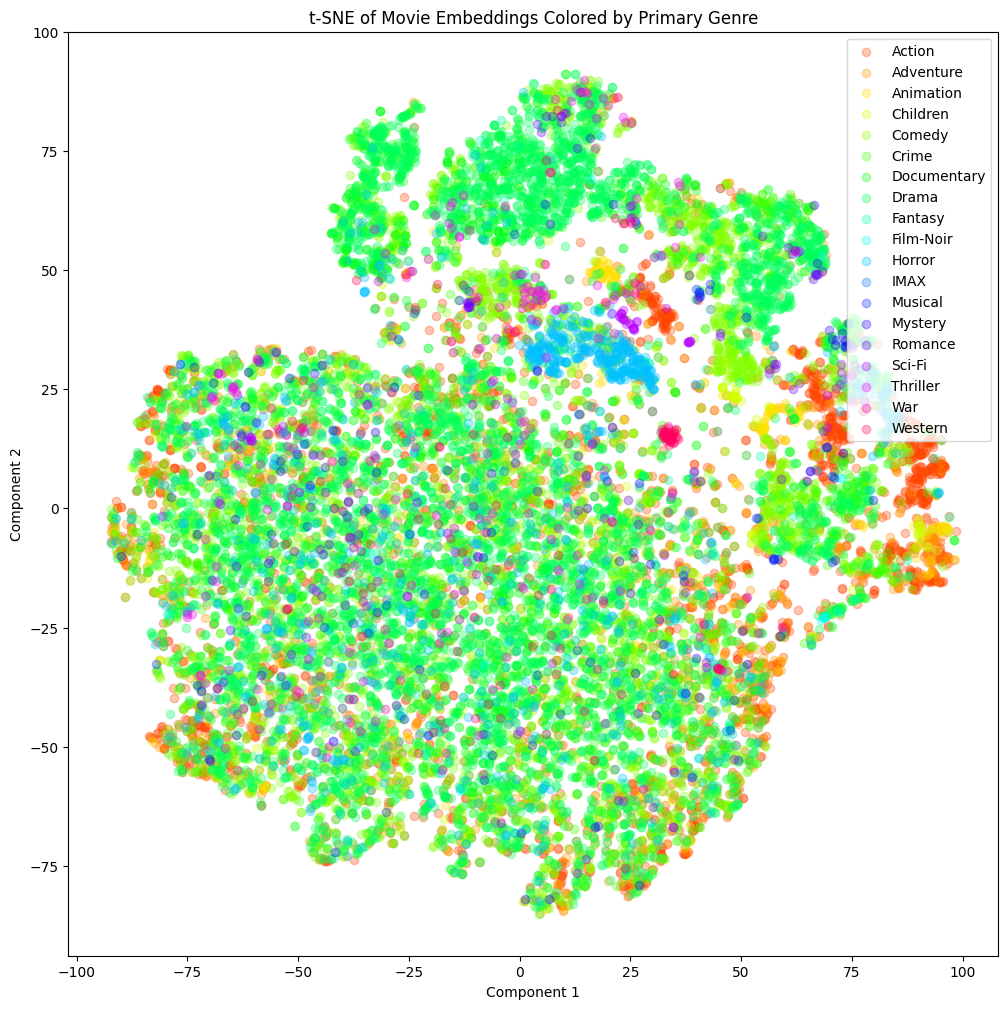

In [288]:
plt.figure(figsize=(12, 12))

for genre in genres:
    genre_data = items_visualization_df[items_visualization_df['primary_genre'] == genre]
    plt.scatter(genre_data['embedding_x'], genre_data['embedding_y'], 
                color=genre_color_map[genre], label=genre, alpha=0.3)

plt.title('t-SNE of Movie Embeddings Colored by Primary Genre')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

We could discern some clusters in the visualization suggesting that the model got to some patterns through the movie embeddings that could be used to explain/interpret the recommendations.

---